#**1. Drive Mount**

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Library Import**

In [1]:
# 라이브러리 임포트
import os
import shutil
import cv2
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import lz4
import mtcnn
import tensorflow as tf
from tensorflow.keras import utils
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.model_selection import train_test_split
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
from tqdm import tqdm
from PIL import Image
from mtcnn.mtcnn import MTCNN

#**3. Image cropping & resizing by maintaining aspect ratio**

In [2]:
def crop_and_resize(image, target_w=224, target_h=224):
  '''이 함수는 비율을 유지하며 이미지를 crop & resize 합니다.'''
  # 이미지가 2차원이면 (흑백이미지)
  if image.ndim == 2:
    img_h, img_w = image.shape
  # 이미지가 3차원이면 (컬러이미지)
  elif image.ndim == 3:
    img_h, img_w, channels = image.shape

  # 목표 이미지의 가로 세로 비율 계산
  target_aspect_ratio = target_w / target_h
  # 입력 이미지의 가로 세로 비율 계산
  input_aspect_ratio = img_w / img_h # img_w, img_h : 원본 이미지 가로 세로

  # 입력 이미지의 가로 비율이 더 큰 경우
  if input_aspect_ratio > target_aspect_ratio:
    # 이미지의 가로 크기 키움, 세로 크기를 목표로 맞추어 리사이즈
    resize_w = int(input_aspect_ratio * target_h)
    resize_h = target_h
    img = cv2.resize(image, (resize_w, resize_h))
    # crop_left와 crop_right 사용해 중앙 영역만 잘라냄
    crop_left = int((resize_w - target_w) / 2)
    crop_right = crop_left + target_w
    new_img = img[:, crop_left:crop_right]

  # 입력 이미지의 세로 비율이 더 큰 경우
  elif input_aspect_ratio < target_aspect_ratio:
    resize_w = target_w
    # 세로 크기를 목표로 맞춤
    resize_h = int(target_w / input_aspect_ratio)
    img = cv2.resize(image, (resize_w, resize_h))
    crop_top = int((resize_h - target_h) / 4)
    crop_bottom = crop_top + target_h
    new_img = img[crop_top:crop_bottom, :]

  # 비율이 같은 경우
  else:
    new_img = cv2.resize(image, (target_w, target_h))

  return new_img

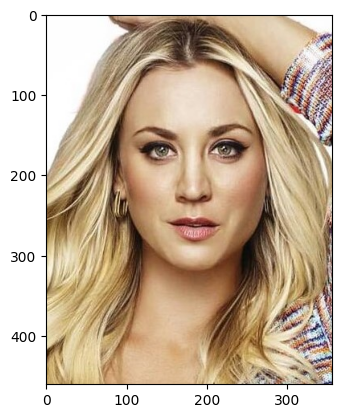

In [31]:
# 원본 이미지 확인
original_img = cv2.imread('FaceShape Dataset/Oval/Oval_0001.jpg')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.imshow(original_img)

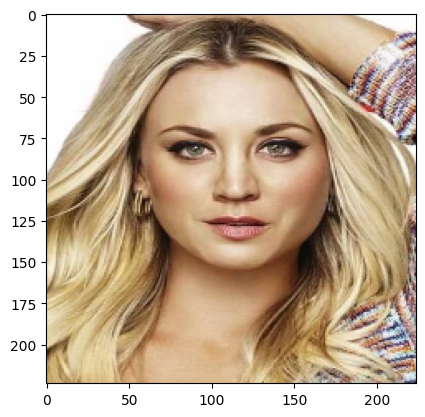

In [32]:
# 자동 resize 후 이미지 : 비율 유지 X
auto_resized_img = cv2.resize(original_img, (224, 224))
plt.imshow(auto_resized_img)

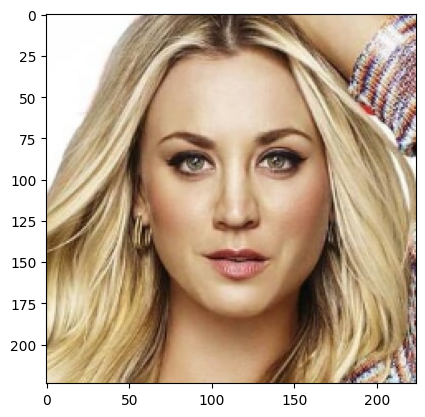

In [33]:
# crop_and_resize 함수로 비율 유지하여 resizing한 이미지
cropped_resized_img = crop_and_resize(original_img)
plt.imshow(cropped_resized_img)

# **4. Face Detection with Bounding Box - Using MTCNN**

In [7]:
# MTCNN 활용한 얼굴 감지 및 추출 함수 정의
def extract_face_with_mtcnn(img_path):
  try:
    # 이미지 로드
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 이미지가 없으면
    if img is None:
      raise ValueError(f"Failed to load image from {img_path}")

    # MTCNN 초기화
    mtcnn = MTCNN()
    # 얼굴 감지
    results = mtcnn.detect_faces(img)
    # 감지된 결과가 없으면
    if len(results == 0):
      raise ValueError('Can not detect face')

    # 첫 번째 얼굴의 바운딩 박스 추출 (MTCNN은 이미지에서 여러 개의 얼굴 감지 가능)
    # x : 얼굴 왼쪽 경계 x 좌표, y : 얼굴 위쪽 경계 y 좌표
    # width : 얼굴 가로 너비, height : 얼굴 세로 높이
    x, y, width, height = results[0]['box']

    # 바운딩 박스를 사용하여 얼굴 영역 추출
    # y:y+height는 세로 방향으로 얼굴 영역 선택
    # x:x+width는 가로 방향으로 얼굴 영역 선택
    face = img[y:y+height, x:x+width]
    return face

  except Exception as e:
    print(f'Fail to img preprocessing : {img_path}\nError : {e}')
    return None

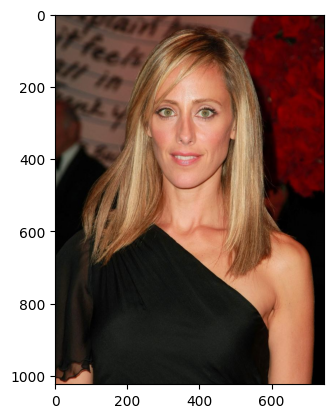

In [34]:
# 원본 이미지
img_mtcnn = cv2.imread('FaceShape Dataset/Oblong/Oblong_0001.jpg')
img_mtcnn = cv2.cvtColor(img_mtcnn, cv2.COLOR_BGR2RGB)
plt.imshow(img_mtcnn)

In [9]:
# MTCNN 생성
detector = MTCNN()
# 얼굴 감지
results = detector.detect_faces(img_mtcnn)
results

[{'box': [256, 140, 226, 322],
  'confidence': 0.9558150768280029,
  'keypoints': {'nose': [359, 340],
   'mouth_right': [410, 388],
   'right_eye': [416, 272],
   'left_eye': [311, 271],
   'mouth_left': [320, 387]}}]

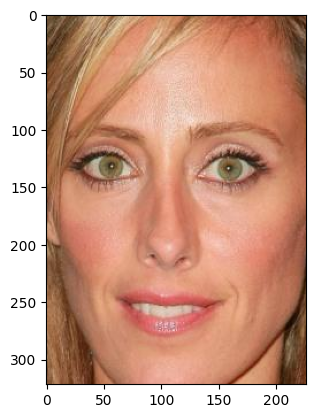

In [10]:
# 얼굴에서 바운딩 박스 추출
# x1, y1 : 얼굴의 좌측 상단 경계 좌표
# width, height : 바운딩 박스의 가로 & 세로 크기
x1, y1, width, height = results[0]['box']
# x2, y2 : 얼굴의 우측 하단 경계 좌표 계산
x2, y2 = x1+width, y1+height

# 얼굴 영역 잘라내기
face = img_mtcnn[y1:y2, x1:x2]
plt.imshow(face)

x1 = 256
x2 = 482
y1 = 140
y2 = 462


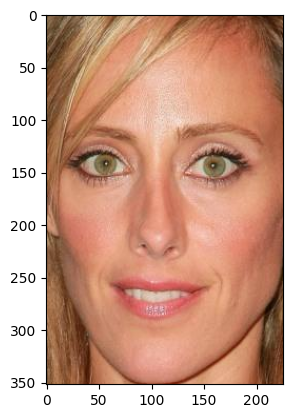

In [11]:
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

# y1 - 10 : 위쪽으로 10픽셀 확장. 얼굴보다 위쪽으로 조금 더 넓은 영역 포함
# y2 + 20 : 아래쪽으로 20픽셀 확장. 원래 얼굴보다 아래쪽으로 더 넓은 영역 포함
face2 = img_mtcnn[y1-10:y2+20, x1:x2]
plt.imshow(face2)

h=352
w=226


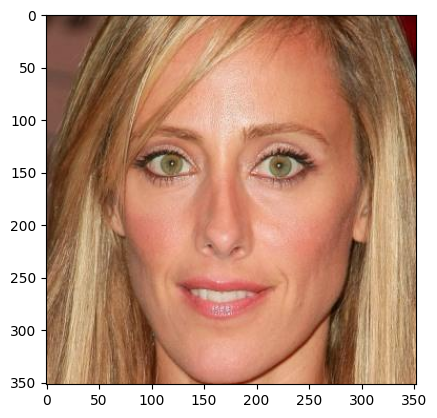

In [12]:
# 얼굴 영역 정사각형 형태로 만들기
h = (y2 + 20) - (y1 - 10) # 얼굴 높이 계산 : 위쪽 & 아래쪽으로 확장한 최종 높이
w = x2 - x1 # 얼굴 너비
print(f'h={h}')
print(f'w={w}')

adj_h = 10 # 세로 방향으로 10픽셀 넓게 조정
adj_w = int((h-w)/2) # (높이 - 너비)를 2로 나누어 양쪽에 동일하게 추가

new_y1 = y1 - adj_h # 위쪽으로 10픽셀 확장
new_y2 = y2 + (adj_h * 2) # 아래쪽으로 20픽셀 확장

new_x1 = x1 - adj_w # 왼쪽으로 확장
new_x2 = x2 + adj_w # 오른쪽으로 확장

new_face = img_mtcnn[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face)

In [13]:
detector = MTCNN()

def extract_face(img, target_size=(224,224)):
  '''this functions extract face from different images by
  1) finds the facial bounding box
  2) slightly expands top & bottom boundaries to include the whole face
  3) crop into a square shape
  4) resize to target image size for modelling'''

  # 1. 이미지에서 얼굴 감지
  results = detector.detect_faces(img)

  # 감지 결과가 없으면
  if results == []:
    # 이미지를 그냥 224 x 224로 crop & resize
    new_face = crop_and_resize(img, target_w=224, target_h=224)

  # 얼굴이 감지되면
  else:
    # 바운딩 박스 좌표 추출
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1+width, y1+height
    face = img[y1:y2, x1:x2]  # 확장 전 바운딩 박스 얼굴 이미지

    # 2. 얼굴 위쪽 & 아래쪽을 각각 10픽셀씩 확장, 얼굴의 모든 부분 포함하도록 함
    adj_h = 10

    # new_y1 : 새로운 위쪽 좌표
    if y1 - adj_h < 10: # 확장했을 때, 이미지 범위 벗어나면
      new_y1 = 0 # 이미지 경계 벗어나지 않도록 0으로 설정
    else:
      new_y1 = y1 - adj_h

    # new_y2 : 새로운 아래쪽 좌표
    if y1 + height + adj_h < img.shape[0]:
      new_y2 = y1 + height + adj_h
    else:
      new_y2 = img.shape[0]

    new_height = new_y2 - new_y1

    # 3. 가로 방향 확장 : 정사각형 만들기
    adj_w = int((new_height - width) / 2)

    # new_x1 : 새로운 왼쪽 경계
    if x1 - adj_w < 0:
      new_x1 = 0
    else:
      new_x1 = x1 - adj_w

    # new_x2 : 새로운 오른쪽 경계
    if x2 + adj_w > img.shape[1]:
      new_x2 = img.shape[1]
    else:
      new_x2 = x2 + adj_w

    # 확장된 바운딩 박스 얼굴 이미지
    new_face = img[new_y1:new_y2, new_x1:new_x2]

  # 4. 이미지 리사이즈
  sqr_img = cv2.resize(new_face, target_size)
  return sqr_img

In [14]:
def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0

    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)

    return(gb_img)

In [35]:
examples = [cv2.imread('FaceShape Dataset/Oval/Oval_0001.jpg'),
            cv2.imread('FaceShape Dataset/Oblong/Oblong_0001.jpg'),
            cv2.imread('FaceShape Dataset/Square/Square_0001.jpg'),
            cv2.imread('FaceShape Dataset/Round/Round_0001.jpg')
            ]

Text(0.77, 0.89, 'Square')

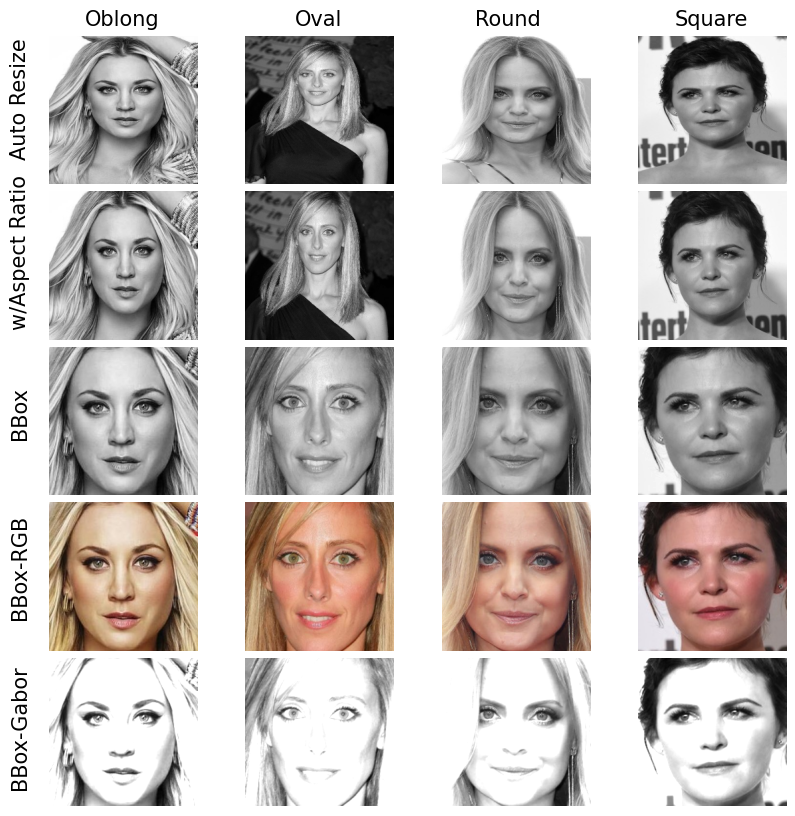

In [36]:
# 예제로 함수 테스트
n_images = len(examples)

fig, ax = plt.subplots(nrows=5, ncols=n_images, figsize=(n_images*2.5, (4*2.5)))
plt.gray()

ax= ax.ravel()

for i, file in enumerate(examples):
  # img : 원본 이미지
  img = file
  # bbox_img : MTCNN으로 얼굴 바운딩 박스 추출 후 이미지
  bbox_img = extract_face(img)

  # 자동 resize 이미지
  rsz_img = cv2.resize(img,(224,224))
  rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
  ax[i].imshow(rsz_img)
  ax[i].axis('off')

  # 비율 유지 crop & resize
  aspct_img = crop_and_resize(img, target_w=224, target_h=224)
  aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
  ax[i+(n_images*1)].imshow(aspct_img)
  ax[i+(n_images*1)].axis('off')

  # 바운딩 박스 추출 후 이미지 (컬러)
  rgb_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)
  ax[i+(n_images*3)].imshow(rgb_img)
  ax[i+(n_images*3)].axis('off')

  # 바운딩 박스 추출 후 이미지 (흑백)
  gray_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2GRAY)
  ax[i+(n_images*2)].imshow(gray_img)
  ax[i+(n_images*2)].axis('off')

  # gabor 필터 적용 후 이미지
  gabor_img = cvt_gabor(gray_img)
  ax[i+(n_images*4)].imshow(gabor_img)
  ax[i+(n_images*4)].axis('off')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

# 세로축 (y축) label
plt.figtext(x=0.105, y=0.76, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.59, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="BBox", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.3, s="BBox-RGB", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.13, s="BBox-Gabor", fontsize=15, rotation=90)

# 가로축 (x축) label
plt.figtext(x=0.18, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.39, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.57, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.77, y=0.89, s="Square", fontsize=15)

#**5. Apply Preprocessing**

In [38]:
# FaceShape 디렉토리 경로
base_dir = 'FaceShape Dataset'
processed_dir = 'Preprocessing FaceShape Dataset'

# 필요한 디렉토리가 없으면 생성
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# 모든 얼굴형 폴더 목록 가져오기
shape_folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# 각 얼굴형 폴더를 처리하고 결과 저장
for shape_folder in shape_folders:
    folder_path = os.path.join(base_dir, shape_folder)
    processed_folder_path = os.path.join(processed_dir, shape_folder)

    # 처리된 이미지를 저장할 폴더 생성
    if not os.path.exists(processed_folder_path):
        os.makedirs(processed_folder_path)

    # 현재 폴더의 파일 목록 가져오기
    filenames = os.listdir(folder_path)

    # 진행 상황을 진행바로 표시하며 파일 처리
    with tqdm(total=len(filenames), desc=f"Processing {shape_folder} folder", unit="file") as pbar:
        for filename in filenames:
            file_path = os.path.join(folder_path, filename)
            try:
                # OpenCV를 사용하여 이미지 파일 읽기
                img = cv2.imread(file_path)

                # 이미지가 제대로 읽혔는지 확인
                if img is None:
                    raise ValueError("Image could not be read, possibly due to an unsupported format.")

                # 얼굴 추출 및 크롭, 리사이즈 수행
                face_img = extract_face(img, target_size=(224, 224))

                # 새로운 파일 경로 설정
                new_file_path = os.path.join(processed_folder_path, filename)

                # OpenCV를 사용하여 처리된 이미지 저장
                cv2.imwrite(new_file_path, face_img)

            except Exception as e:
                # 오류 발생 시 오류 메시지 출력
                print(f"Error processing {filename}: {e}")

            # 진행바 업데이트
            pbar.update(1)

print("Face detection and preprocessing completed for all images.")

Processing Square folder: 100%|██████████| 1197/1197 [02:47<00:00,  7.14file/s]

Face detection and preprocessing completed for all images.


#**6. Split Train & Test Set**

In [39]:
# 전처리된 이미지들이 있는 디렉토리 경로
processed_dir = 'Preprocessing FaceShape Dataset'

# train, validation, test 데이터셋을 저장할 디렉토리 경로
train_dir = 'train'
validation_dir = 'validation'
test_dir = 'test'

# 필요한 디렉토리가 없으면 생성
for directory in [train_dir, validation_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# 클래스별 최소 데이터 개수 확인
file_count = 0
min_images = float('inf')

for class_name in os.listdir(processed_dir):
    # 현재 폴더 경로
    folder_path = os.path.join(processed_dir, class_name)

    if os.path.isdir(folder_path):
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        file_count = len(images)
        min_images = min(min_images, file_count)


# 각 얼굴형 폴더를 train, validation, test로 나누어 저장
for class_name in os.listdir(processed_dir):
    # 현재 폴더 경로
    folder_path = os.path.join(processed_dir, class_name)

    if os.path.isdir(folder_path):
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        # 최소 데이터 개수만큼만 사용
        images = images[:min_images]

        # train, validation, test 폴더 내부에도 같은 얼굴형 폴더 생성
        train_folder_path = os.path.join(train_dir, class_name)
        validation_folder_path = os.path.join(validation_dir, class_name)
        test_folder_path = os.path.join(test_dir, class_name)

        for directory in [train_folder_path, validation_folder_path, test_folder_path]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # 8:2 비율로 train과 test 파일 나누기
        train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

        # train 파일 중 20%를 validation으로 나누기
        train_files, validation_files = train_test_split(train_files, test_size=0.2, random_state=42)

        # train 파일 복사
        for filename in train_files:
            src_path = os.path.join(folder_path, filename)
            dest_path = os.path.join(train_folder_path, filename)
            shutil.copyfile(src_path, dest_path)

        # validation 파일 복사
        for filename in validation_files:
            src_path = os.path.join(folder_path, filename)
            dest_path = os.path.join(validation_folder_path, filename)
            shutil.copyfile(src_path, dest_path)

        # test 파일 복사
        for filename in test_files:
            src_path = os.path.join(folder_path, filename)
            dest_path = os.path.join(test_folder_path, filename)
            shutil.copyfile(src_path, dest_path)

print("Train, validation, and test dataset split completed.")

Train, validation, and test dataset split completed.
